# 02 - Evolving CartPole Controllers
### [Last Update: February 2022][![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RobertTLange/evosax/blob/main/examples/02_mlp_control.ipynb)

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

!pip install -q evosax

import jax
import jax.numpy as jnp

## Open-ES with MLP Controller

In [2]:
from evosax import Open_ES, ParameterReshaper, FitnessShaper, NetworkMapper
from evosax.utils import ESLog
from evosax.problems import GymFitness

rng = jax.random.PRNGKey(0)
network = NetworkMapper["MLP"](
    num_hidden_units=64,
    num_hidden_layers=2,
    num_output_units=2,
    hidden_activation="relu",
    output_activation="categorical",
)
pholder = jnp.zeros((4,))
params = network.init(
    rng,
    x=pholder,
    rng=rng,
)

param_reshaper = ParameterReshaper(params['params'])

In [3]:
evaluator = GymFitness("CartPole-v1", num_env_steps=200)
evaluator.set_apply_fn(network.apply)
rollout = jax.jit(jax.vmap(evaluator.rollout, in_axes=(None, param_reshaper.vmap_dict)))

In [4]:
strategy = Open_ES(popsize=100,
                   num_dims=param_reshaper.total_params,
                   opt_name="sgd")

es_params = {
        "lrate_init": 0.01,  # Initial learning rate
        "lrate_decay": 0.999, # Multiplicative decay factor
        "lrate_limit": 0.001,  # Smallest possible lrate
        "momentum": 0.0,  # Momentum coefficient
        "sigma_init": 0.02,  # Initial scale of isotropic Gaussian noise
        "sigma_decay": 0.999,  # Multiplicative decay factor
        "sigma_limit": 0.01,  # Smallest possible scale
        "init_min": -0.1,  # Range of parameter archive initialization - Min
        "init_max": 0.1,  # Range of parameter archive initialization - Max
        "clip_min": -10,  # Range of parameter proposals - Min
        "clip_max": 10  # Range of parameter proposals - Max
}

In [5]:
num_generations = 200
num_rollouts = 20
print_every_k_gens = 20

es_logging = ESLog(param_reshaper.total_params,
                   num_generations,
                   top_k=5,
                   maximize=True)
log = es_logging.initialize()

fit_shaper = FitnessShaper(centered_rank=True,
                           z_score=True,
                           w_decay=0.1,
                           maximize=True)

state = strategy.initialize(rng, es_params)

for gen in range(num_generations):
    rng, rng_init, rng_ask, rng_eval = jax.random.split(rng, 4)
    x, state = strategy.ask(rng_ask, state, es_params)
    reshaped_params = param_reshaper.reshape(x)
    batch_rng = jax.random.split(rng_eval, num_rollouts)
    fitness = rollout(batch_rng, reshaped_params).mean(axis=1)
    fit_re = fit_shaper.apply(x, fitness)
    state = strategy.tell(x, fit_re, state, es_params)
    log = es_logging.update(log, x, fitness)
    
    if gen % print_every_k_gens == 0:
        print("Generation: ", gen, "Generation: ", log["log_top_1"][gen])

Generation:  0 Generation:  31.15
Generation:  20 Generation:  73.05
Generation:  40 Generation:  200.0
Generation:  60 Generation:  200.0
Generation:  80 Generation:  200.0
Generation:  100 Generation:  200.0
Generation:  120 Generation:  200.0
Generation:  140 Generation:  200.0
Generation:  160 Generation:  200.0
Generation:  180 Generation:  200.0


(<Figure size 432x216 with 1 Axes>,
 <AxesSubplot:title={'center':'CartPole OpenAI-ES'}, xlabel='Number of Generations', ylabel='Fitness Score'>)

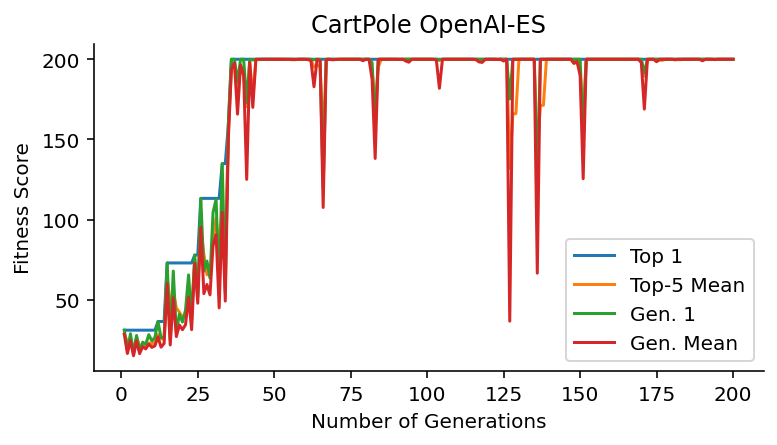

In [6]:
es_logging.plot(log, "CartPole MLP OpenAI-ES")

# PGPE with LSTM Controller

In [22]:
rng = jax.random.PRNGKey(0)
network = NetworkMapper["LSTM"](
    num_hidden_units=32,
    num_output_units=2,
    output_activation="categorical",
)
pholder = jnp.zeros((4,))
carry_init = network.initialize_carry()
params = network.init(
    rng,
    x=pholder,
    carry=carry_init,
    rng=rng,
)

param_reshaper = ParameterReshaper(params['params'])

In [23]:
evaluator = GymFitness()
evaluator.set_apply_fn(network.apply, network.initialize_carry)
rollout = jax.jit(jax.vmap(evaluator.rollout, in_axes=(None, param_reshaper.vmap_dict)))

In [24]:
from evosax import PGPE_ES

popsize = 100
strategy = PGPE_ES(param_reshaper.total_params, popsize, elite_ratio=0.1, opt_name="adam")
params = strategy.default_params

es_params = {
        "lrate_init": 0.05,  # Initial learning rate
        "lrate_decay": 0.999, # Multiplicative decay factor
        "lrate_limit": 0.01,  # Smallest possible lrate
        "beta_1": 0.99,   # Adam - beta_1
        "beta_2": 0.999,  # Adam - beta_2
        "eps": 1e-8,  # eps constant,
        "sigma_init": 0.05,  # Initial scale of isotropic Gaussian noise
        "sigma_decay": 0.999,  # Multiplicative decay factor
        "sigma_limit": 0.01,  # Smallest possible scale
        "sigma_lrate": 0.2,  # Learning rate for scale
        "sigma_max_change": 0.2,  # clips adaptive sigma to 20%
        "init_min": -0.1,  # Range of parameter archive initialization - Min
        "init_max": 0.1,  # Range of parameter archive initialization - Max
        "clip_min": -10,  # Range of parameter proposals - Min
        "clip_max": 10  # Range of parameter proposals - Max
}

In [25]:
num_generations = 200
num_rollouts = 20
print_every_k_gens = 20

es_logging = ESLog(param_reshaper.total_params,
                   num_generations,
                   top_k=5,
                   maximize=True)
log = es_logging.initialize()

fit_shaper = FitnessShaper(w_decay=0.1,
                           maximize=True)

state = strategy.initialize(rng, es_params)

for gen in range(num_generations):
    rng, rng_init, rng_ask, rng_eval = jax.random.split(rng, 4)
    x, state = strategy.ask(rng_ask, state, es_params)
    reshaped_params = param_reshaper.reshape(x)
    batch_rng = jax.random.split(rng_eval, num_rollouts)
    fitness = rollout(batch_rng, reshaped_params).mean(axis=1)
    fit_re = fit_shaper.apply(x, fitness)
    state = strategy.tell(x, fit_re, state, es_params)
    log = es_logging.update(log, x, fitness)
    
    if gen % print_every_k_gens == 0:
        print("Generation: ", gen, "Generation: ", log["log_top_1"][gen])

Generation:  0 Generation:  23.7
Generation:  20 Generation:  66.0
Generation:  40 Generation:  196.2
Generation:  60 Generation:  200.0
Generation:  80 Generation:  200.0
Generation:  100 Generation:  200.0
Generation:  120 Generation:  200.0
Generation:  140 Generation:  200.0
Generation:  160 Generation:  200.0
Generation:  180 Generation:  200.0


(<Figure size 432x216 with 1 Axes>,
 <AxesSubplot:title={'center':'CartPole LSTM PGPE'}, xlabel='Number of Generations', ylabel='Fitness Score'>)

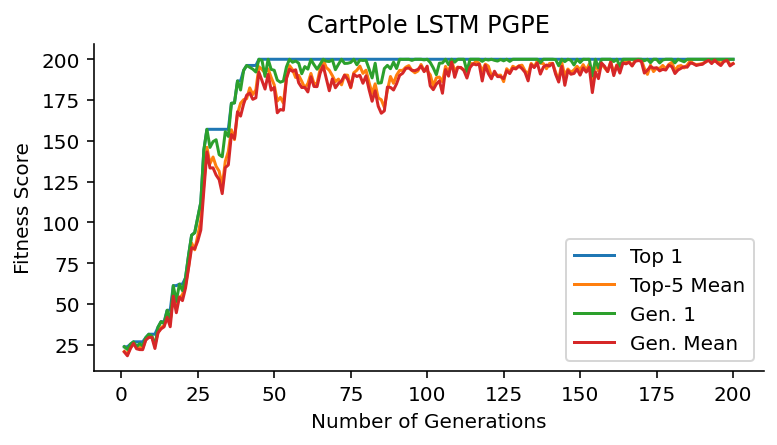

In [26]:
es_logging.plot(log, "CartPole LSTM PGPE")